# character rnn workshop

designed to give some hands on exposure to a chracter rnn

## setup

In [1]:
! pip install -r requirements.txt

In [2]:
# filesystem and data downloading libraries
import os # for filesystem operations
import requests # for interacting with webpages to get data
from zipfile import ZipFile # unzip in python to keep it all in one place\
import glob # easy file matching

# numerical libraries
import random

# text processing libraries
import string
import unicodedata

import time

# deep learning library
import torch # mostly for tensors
import torch.nn as nn # the Neural Networks module from torch. nn by convention

# plotting library
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker


## Getting the data

In [3]:
# premade
url = 'https://download.pytorch.org/tutorial/data.zip'

# data download and file managment
if not os.path.isdir('data'):
    os.mkdir('data')
if not os.path.isfile('data/name_data.zip'):
    r = requests.get(url) # download the data
    with open('data/name_data.zip', 'wb') as f:
        f.write(r.content) # save the data to a file

# extract the data
with ZipFile('data/name_data.zip', 'r') as data_zip:
   # Extract all the contents of the data zip file in to the data directory
   data_zip.extractall()

# Look at the folders and the file contents

In [4]:
# livecode
os.listdir('data/names')
with open('data/names/Arabic.txt') as f:
    lines = [line for line in f]
print(len(lines), lines[:10])

2000 ['Khoury\n', 'Nahas\n', 'Daher\n', 'Gerges\n', 'Nazari\n', 'Maalouf\n', 'Gerges\n', 'Naifeh\n', 'Guirguis\n', 'Baba\n']


In [5]:
fnames = glob.glob('data/names/*.txt')
fnames

['data/names/Czech.txt',
 'data/names/German.txt',
 'data/names/Arabic.txt',
 'data/names/Japanese.txt',
 'data/names/Chinese.txt',
 'data/names/Vietnamese.txt',
 'data/names/Russian.txt',
 'data/names/French.txt',
 'data/names/Irish.txt',
 'data/names/English.txt',
 'data/names/Spanish.txt',
 'data/names/Greek.txt',
 'data/names/Italian.txt',
 'data/names/Portuguese.txt',
 'data/names/Scottish.txt',
 'data/names/Dutch.txt',
 'data/names/Korean.txt',
 'data/names/Polish.txt']

## Loading the data

### Helper functions

In [6]:
# premade
def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

def clean_names(name):
    return unicode_to_ascii(name.strip())

In [7]:
# livecode
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)
n_letters, all_letters

(57, "abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'")

In [8]:
# livecode
all_languages = [] # list of language names
language_names = {} # dict of key = language, value = list of all names in that language
for fname in fnames:
    with open(fname, 'r') as f:
        language = os.path.basename(fname)[:-4]
        names = [clean_names(line) for line in f]
        all_languages.append(language)
        language_names[language] = names
n_languages = len(all_languages)
print(n_languages, all_languages)

18 ['Czech', 'German', 'Arabic', 'Japanese', 'Chinese', 'Vietnamese', 'Russian', 'French', 'Irish', 'English', 'Spanish', 'Greek', 'Italian', 'Portuguese', 'Scottish', 'Dutch', 'Korean', 'Polish']


## Data as tensors (vectors)

In [9]:
# livecode helper functions
def character_to_tensor(c):
    t = torch.zeros(1, n_letters) # size of tensor (1,n)
    t[0, all_letters.find(c)] = 1 # set to one at index of character
    return t

def word_to_tensor(word):
    w = torch.zeros(len(word), 1, n_letters) # size of tensor (w, 1, n)
    for i, c in enumerate(word):
        w[i,0,all_letters.find(c)] = 1
    return w

def word_to_tensor_cat(word):
    # maybe dont include as it has unsqueezing
    character_vectors = [character_to_tensor(c) for c in word]
    return torch.cat(character_vectors).unsqueeze(1)

In [10]:
character_to_tensor('a').size()#, character_to_tensor('a')

torch.Size([1, 57])

In [11]:
word_to_tensor('abc').size()#, word_to_tensor('abc')

torch.Size([3, 1, 57])

In [12]:
word_to_tensor_cat('abc').size()#, word_to_tensor_cat('abc')

torch.Size([3, 1, 57])

## Sampling the data

In [13]:
def random_choice(l):
    return l[random.randint(0,len(l)-1)]
    
def random_language_name(language=None):
    """returns all the information for a random language-name pair"""
    if not(language):
        language = random_choice(all_languages)
    name = random_choice(language_names[language])
    
    language_index = all_languages.index(language)
    language_tensor = torch.tensor([language_index], dtype=torch.long)
    name_tensor = word_to_tensor(name)
    return language, name, language_tensor, name_tensor

In [14]:
random_language_name()

('Czech',
 'Gavalok',
 tensor([0]),
 tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0.]],
 
         [[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0.]],
 
         [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0.]],
 
         [[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

In [15]:
for i in range(10):
    lang, name, lang_t, name_t = random_language_name()
    print("language: ", lang,  lang_t, "name: ", name, name_t.size())

language:  Dutch tensor([15]) name:  Kloeten torch.Size([7, 1, 57])
language:  Vietnamese tensor([5]) name:  Luong torch.Size([5, 1, 57])
language:  Polish tensor([17]) name:  Nosek torch.Size([5, 1, 57])
language:  Dutch tensor([15]) name:  Rompaij torch.Size([7, 1, 57])
language:  English tensor([9]) name:  Robertson torch.Size([9, 1, 57])
language:  Chinese tensor([4]) name:  Guang torch.Size([5, 1, 57])
language:  Chinese tensor([4]) name:  Weng torch.Size([4, 1, 57])
language:  Czech tensor([0]) name:  Hanzlick torch.Size([8, 1, 57])
language:  German tensor([1]) name:  Klossner torch.Size([8, 1, 57])
language:  Russian tensor([6]) name:  Kalinkin torch.Size([8, 1, 57])


## The network!

This is the specific RNN structure that we want to be building:
![network diagram](network_structure.png)

In [16]:
#livecode
class RNN(nn.Module):
    """This dictates the structure and size of the network"""
    def __init__(self, data_size, hidden_size, output_size):
        """Sets up class attributes and layers"""
        super(RNN, self).__init__()
        self.combined_input_size = data_size + hidden_size
        self.hidden_size = hidden_size
        
        # fully connected layers
        self.i2o = nn.Linear(self.combined_input_size, output_size) 
        self.i2h = nn.Linear(self.combined_input_size, hidden_size) 
        
        #softmax to turn output into probability
        self.softmax = nn.Softmax(dim=1) 
    
    def forward(self, x, last_hidden):
        """Describes how data moves through the RNN"""
        combined_input = torch.cat([x, last_hidden], dim=1)
        output = self.i2o(combined_input)
        hidden = self.i2h(combined_input)
        output_probabilities = self.softmax(output)
        return output_probabilities, hidden
        

In [17]:
n_hidden = 128
hidden_start = torch.zeros(1,n_hidden)
rnn = RNN(n_letters, n_hidden, n_languages)

In [18]:
output, hidden = rnn(character_to_tensor('a'), hidden_start)

In [19]:
output.size(), output 

(torch.Size([1, 18]),
 tensor([[0.0557, 0.0583, 0.0613, 0.0580, 0.0508, 0.0619, 0.0494, 0.0560, 0.0558,
          0.0548, 0.0559, 0.0512, 0.0583, 0.0570, 0.0513, 0.0563, 0.0558, 0.0524]],
        grad_fn=<SoftmaxBackward>))

In [20]:
output.sum()

tensor(1.0000, grad_fn=<SumBackward0>)

In [21]:
hidden.size()#, hidden

torch.Size([1, 128])

### making sense of model output

In [22]:
# live code
def language_from_output(output):
    top_n, top_i = output.topk(1) # gives the top 1 score and index
    index = top_i[0].item() # convert tensor to float
    score = top_n[0].item()
    language = all_languages[index]
    return language, index, score

In [23]:
language_from_output(output)

('Vietnamese', 5, 0.06190158799290657)

## Training

In [24]:
criterion = nn.NLLLoss() # negative log likelihood loss. Convention
lr = 0.005 # starter learning rate

def infer(rnn, name_t):
    hidden = torch.zeros(1,rnn.hidden_size) # initial zero hidden state
    rnn.zero_grad() # removes all gradients from last time
    # loops over the name, passing the hidden vector along each time
    for i in range(name_t.size(0)):
        output, hidden = rnn(name_t[i], hidden) 
    return output

def train_step(lang_t, name_t):
    
    output = infer(rnn, name_t)
    
    log_likelihood = torch.log(output) # convert to log cause math
    
    # how wrong are we?
    loss = criterion(log_likelihood, lang_t)
    
    # automagick backpropagation
    loss.backward()
    
    for p in rnn.parameters():
        p.data.add_(-lr, p.grad.data)
    return output, loss.item()

In [25]:
lang, name, lang_t, name_t = random_language_name()
train_step(lang_t, name_t)

(tensor([[0.0540, 0.0574, 0.0603, 0.0582, 0.0533, 0.0523, 0.0542, 0.0505, 0.0550,
          0.0607, 0.0571, 0.0568, 0.0560, 0.0593, 0.0479, 0.0606, 0.0551, 0.0511]],
        grad_fn=<SoftmaxBackward>), 2.8251774311065674)

In [26]:
def time_since(start):
    """little helper for pretty timestamping"""
    now = time.time()
    dt = now - start
    mins = int(dt/60)
    return f'{mins:>02}:{dt - mins*60:>05.2f}(m:s)'
    
def train(rnn, n_iters):
    eval_every = (n_iters//10)
    losses = []
    confusions = []
    start = time.time()
    for i in range(n_iters):
        lang, name, lang_t, name_t = random_language_name()
        output, loss = train_step(lang_t, name_t)
        losses.append(loss)
        
        if (i+1)%eval_every==0 :
                av_loss = sum(losses[-eval_every:])/eval_every
                print(f'iter = {i+1:<6} training time = {time_since(start)} %done = {i/n_iters*100:<5.0f}% loss = {av_loss:<10.4f}')
        

In [27]:
train(rnn, 10000)

iter = 1000   training time = 00:01.43(m:s) %done = 10   % loss = 2.8696    
iter = 2000   training time = 00:02.77(m:s) %done = 20   % loss = 2.8195    
iter = 3000   training time = 00:04.13(m:s) %done = 30   % loss = 2.7798    
iter = 4000   training time = 00:05.47(m:s) %done = 40   % loss = 2.7219    
iter = 5000   training time = 00:06.78(m:s) %done = 50   % loss = 2.6149    
iter = 6000   training time = 00:08.09(m:s) %done = 60   % loss = 2.4936    
iter = 7000   training time = 00:09.58(m:s) %done = 70   % loss = 2.4028    
iter = 8000   training time = 00:11.09(m:s) %done = 80   % loss = 2.3427    
iter = 9000   training time = 00:13.12(m:s) %done = 90   % loss = 2.2361    
iter = 10000  training time = 00:14.71(m:s) %done = 100  % loss = 2.1952    


## Measure of success: Confusion

In [28]:
# live code 
def language_confusion(rnn, language, n_samples = 100):
    language_predicted = {l:0 for l in all_languages}
    for i in range(n_samples):
        lang, name, lang_t, name_t = random_language_name(language=language)
        output = infer(rnn, name_t)
        guess_lang, guess_index, _ = language_from_output(output)
        language_predicted[guess_lang]+=1
        norm_predictions = {l:count/n_samples for l, count in language_predicted.items()}
    return norm_predictions

In [29]:
language_confusion(rnn, "Japanese")

{'Czech': 0.0,
 'German': 0.0,
 'Arabic': 0.09,
 'Japanese': 0.38,
 'Chinese': 0.03,
 'Vietnamese': 0.08,
 'Russian': 0.16,
 'French': 0.0,
 'Irish': 0.0,
 'English': 0.0,
 'Spanish': 0.04,
 'Greek': 0.0,
 'Italian': 0.13,
 'Portuguese': 0.02,
 'Scottish': 0.04,
 'Dutch': 0.0,
 'Korean': 0.0,
 'Polish': 0.03}

In [30]:
def evaluate_confusion(rnn, n_samples = 1000):
    confusion = torch.zeros(n_languages, n_languages)
    for i in range(n_samples):
        lang, name, lang_t, name_t = random_language_name()
        output = infer(rnn,name_t)
        guess_lang, guess_index, _ = language_from_output(output)
        confusion[all_languages.index(lang),guess_index] += 1

        # Normalize by dividing every row by its sum
    for i in range(n_languages):
        confusion[i] = confusion[i] / confusion[i].sum()
    return confusion
def plot_confusion(confusion):
    # Set up plot
    fig = plt.figure(facecolor='white',figsize=(5,5))
    ax = fig.add_subplot(111)
    cax = ax.matshow(confusion.numpy())
    fig.colorbar(cax)
    # Set up axes
    ax.set_xticklabels([''] + all_languages, rotation=90)
    ax.set_yticklabels([''] + all_languages)

    # Force label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    plt.show()

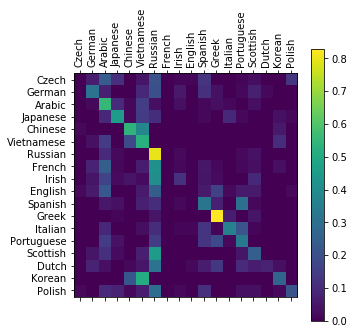

In [31]:
confusion = evaluate_confusion(rnn, n_samples = 1000)
plot_confusion(confusion)